In [1]:
# Ml modules 
import sklearn

# common modules imports
import numpy as np
import pandas as pd
# for visualizations
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider
import pandas as pd
import os

from dotenv import load_dotenv



# Loading data

In [2]:
load_dotenv()

secure_bundle = os.getenv('secure_bundle')
client_id = os.getenv('client_id')
client_secret = os.getenv('client_secret')

cloud_config= {
        'secure_connect_bundle': secure_bundle  
}

# print(cloud_config)

auth_provider = PlainTextAuthProvider(client_id, client_secret)
cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider)
session = cluster.connect()

train_df = pd.DataFrame(list(session.execute('SELECT * FROM stroke.data;')))
train_df.drop(columns=["id"],inplace=True)
train_df.tail(1)

,calc,cond,gravity,osmo,ph,target,urea
413,3.16,25.7,1.021,442,5.53,0,398


In [3]:
features = ['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']
target_feature = ['target']

# Exploratory Data Analysis

## About The Data and features

To predict the presence of kidney stones based on urine analysis. the urine specimens, analyzed in an effort to determine if certain physical characteristics of the urine might be related to the formation of calcium oxalate crystals.

-  The `six physical` characteristics/`features` of the urine are:
    
    -  (1) `specific gravity`, the density of the urine relative to water. 
    -  (2) `pH`, the negative logarithm of the hydrogen ion.
    -  (3) `osmolarity (mOsm)`, a unit used in biology and medicine but not in physical chemistry. Osmolarity is  proportional to the concentration of molecules in solution.
    -  (4) `conductivity (mMho milliMho)`, One Mho is one reciprocal Ohm. Conductivity is proportional to the concentration of charged ions in solution.
    -  (5) `urea concentration in millimoles per litre.`
    -  (6) `calcium concentration (CALC) in millimolesllitre.`


# More information about features


- `Specific gravity` is a measure of the density of a substance compared to the density of water. 
In the context of urine and kidney stones, specific gravity is used as a diagnostic tool to evaluate the concentration of solutes in the urine.
When a person has kidney stones, the concentration of solutes in their urine can be high, leading to a higher specific gravity.
A specific gravity value above 1.020 is considered high and may indicate the presence of kidney stones or other urinary tract problems.
- `pH` of urine is a measure of its acidity or alkalinity. In the context of kidney stones, urine pH is an important factor as it can affect the formation of different types of kidney stones.
Most kidney stones are formed from calcium oxalate, which tends to form in acidic urine. Therefore, if the urine pH is too acidic (less than 5.5), it can increase the risk of calcium oxalate stone formation. On the other hand, if the urine pH is too alkaline (greater than 7.2), it can increase the risk of calcium phosphate stone formation.
Urinary tract infections (UTIs) can also affect urine pH. UTIs can increase the pH of urine, making it more alkaline, which can increase the risk of struvite stone formation.Therefore, measuring urine pH can be helpful in determining the type of kidney stone a person is likely to form and can help in devising preventive strategies.
- `Osmolarity` is a measure of the concentration of solutes in a solution. It can provide information about the concentration of solutes that can contribute to stone formation. High osmolarity in urine means that there are higher amounts of solutes, such as calcium, oxalate, and uric acid, which can lead to the formation of kidney stones. In contrast, low osmolarity indicates that the urine is more dilute and contains fewer solutes, which may reduce the risk of stone formation.
- `conductivity` of urine refers to the concentration of dissolved ions in the urine.conductivity can be used as a diagnostic tool to determine the presence of certain types of stones. For example, calcium-based stones tend to be highly conductive, while other types of stones, such as uric acid stones, are less conductive.
- `Urea` is a waste product that is produced by the liver during the breakdown of proteins and is excreted in the urine. measuring the concentration of urea in the urine can provide information about the solute concentration, which can contribute to the formation of kidney stones.High urea concentration in urine can indicate dehydration or a high protein diet, both of which can increase the risk of stone formation. However, low urea concentration may also indicate certain medical conditions, such as liver disease or low protein intake, which can affect the formation of kidney stones.
- `concentration of calcium` in the urine can provide information about the risk of stone formation.Most kidney stones are made up of calcium oxalate, and high levels of calcium in the urine can increase the risk of stone formation. However, low levels of calcium in the urine can also increase the risk of stone formation, as it can lead to an increase in oxalate levels, which can contribute to stone formation.<br>

In [4]:
# Taking a look at data
train_df.head(5)

,calc,cond,gravity,osmo,ph,target,urea
0,1.53,23.6,1.007,704,5.87,0,260
1,0.65,10.9,1.007,242,6.88,1,14
2,7.82,29.5,1.024,866,5.6,0,360
3,4.49,20.0,1.025,442,6.27,1,398
4,2.17,8.1,1.017,527,5.58,0,170


In [5]:
train_df.isnull().any()

calc       False
cond       False
gravity    False
osmo       False
ph         False
target     False
urea       False
dtype: bool

In [6]:
train_df.dtypes

calc       object
cond       object
gravity    object
osmo        int64
ph         object
target      int64
urea        int64
dtype: object

In [7]:
def change_dtype(df,col):
    df[col] = df[col].astype(float)

In [8]:
change_dtype(train_df,"cond")
change_dtype(train_df,"calc")
change_dtype(train_df,"gravity")
change_dtype(train_df,"ph")
change_dtype(train_df,"ph")

In [9]:
train_df.dtypes

calc       float64
cond       float64
gravity    float64
osmo         int64
ph         float64
target       int64
urea         int64
dtype: object

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   calc     414 non-null    float64
 1   cond     414 non-null    float64
 2   gravity  414 non-null    float64
 3   osmo     414 non-null    int64  
 4   ph       414 non-null    float64
 5   target   414 non-null    int64  
 6   urea     414 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 22.8 KB


<span style="color:green">The data dosent contain any null value and all features are numeric </span>


In [11]:
train_df.describe()

,calc,cond,gravity,osmo,ph,target,urea
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,4.114638,21.437923,1.017894,651.545894,5.955459,0.444444,278.657005
std,3.217641,7.514750,0.006675,234.676567,0.642260,0.497505,136.442249
min,0.170000,5.100000,1.005000,187.000000,4.760000,0.000000,10.000000
25%,1.450000,15.500000,1.012000,455.250000,5.530000,0.000000,170.000000
50%,3.130000,22.200000,1.018000,679.500000,5.740000,0.000000,277.000000
75%,6.630000,27.600000,1.022000,840.000000,6.280000,1.000000,385.000000
max,14.340000,38.000000,1.040000,1236.000000,7.940000,1.000000,620.000000


In [12]:
train_df[train_df.target==0].describe()

,calc,cond,gravity,osmo,ph,target,urea
count,230.000000,230.000000,230.000000,230.000000,230.000000,230.0,230.000000
mean,2.771000,20.281739,1.016209,600.230435,6.009957,0.0,246.330435
std,2.485407,8.214383,0.006853,239.357973,0.669351,0.0,137.926613
min,0.170000,5.100000,1.005000,187.000000,4.760000,0.0,10.000000
25%,1.190000,12.250000,1.010000,416.000000,5.530000,0.0,133.000000
50%,2.160000,21.400000,1.017000,577.000000,5.860000,0.0,205.500000
75%,3.340000,26.000000,1.021000,779.000000,6.297500,0.0,358.500000
max,13.000000,38.000000,1.040000,1236.000000,7.940000,0.0,620.000000


In [13]:
train_df[train_df.target==1].describe()

,calc,cond,gravity,osmo,ph,target,urea
count,184.000000,184.000000,184.000000,184.000000,184.000000,184.0,184.000000
mean,5.794185,22.883152,1.020000,715.690217,5.887337,1.0,319.065217
std,3.245014,6.263311,0.005809,212.486494,0.601572,0.0,123.504811
min,0.170000,5.100000,1.007000,225.000000,4.810000,1.0,14.000000
25%,3.265000,17.900000,1.017000,543.000000,5.530000,1.0,214.000000
50%,5.540000,23.600000,1.021000,742.500000,5.680000,1.0,321.000000
75%,7.715000,27.600000,1.024000,874.000000,6.195000,1.0,396.500000
max,14.340000,38.000000,1.040000,1236.000000,7.920000,1.0,620.000000


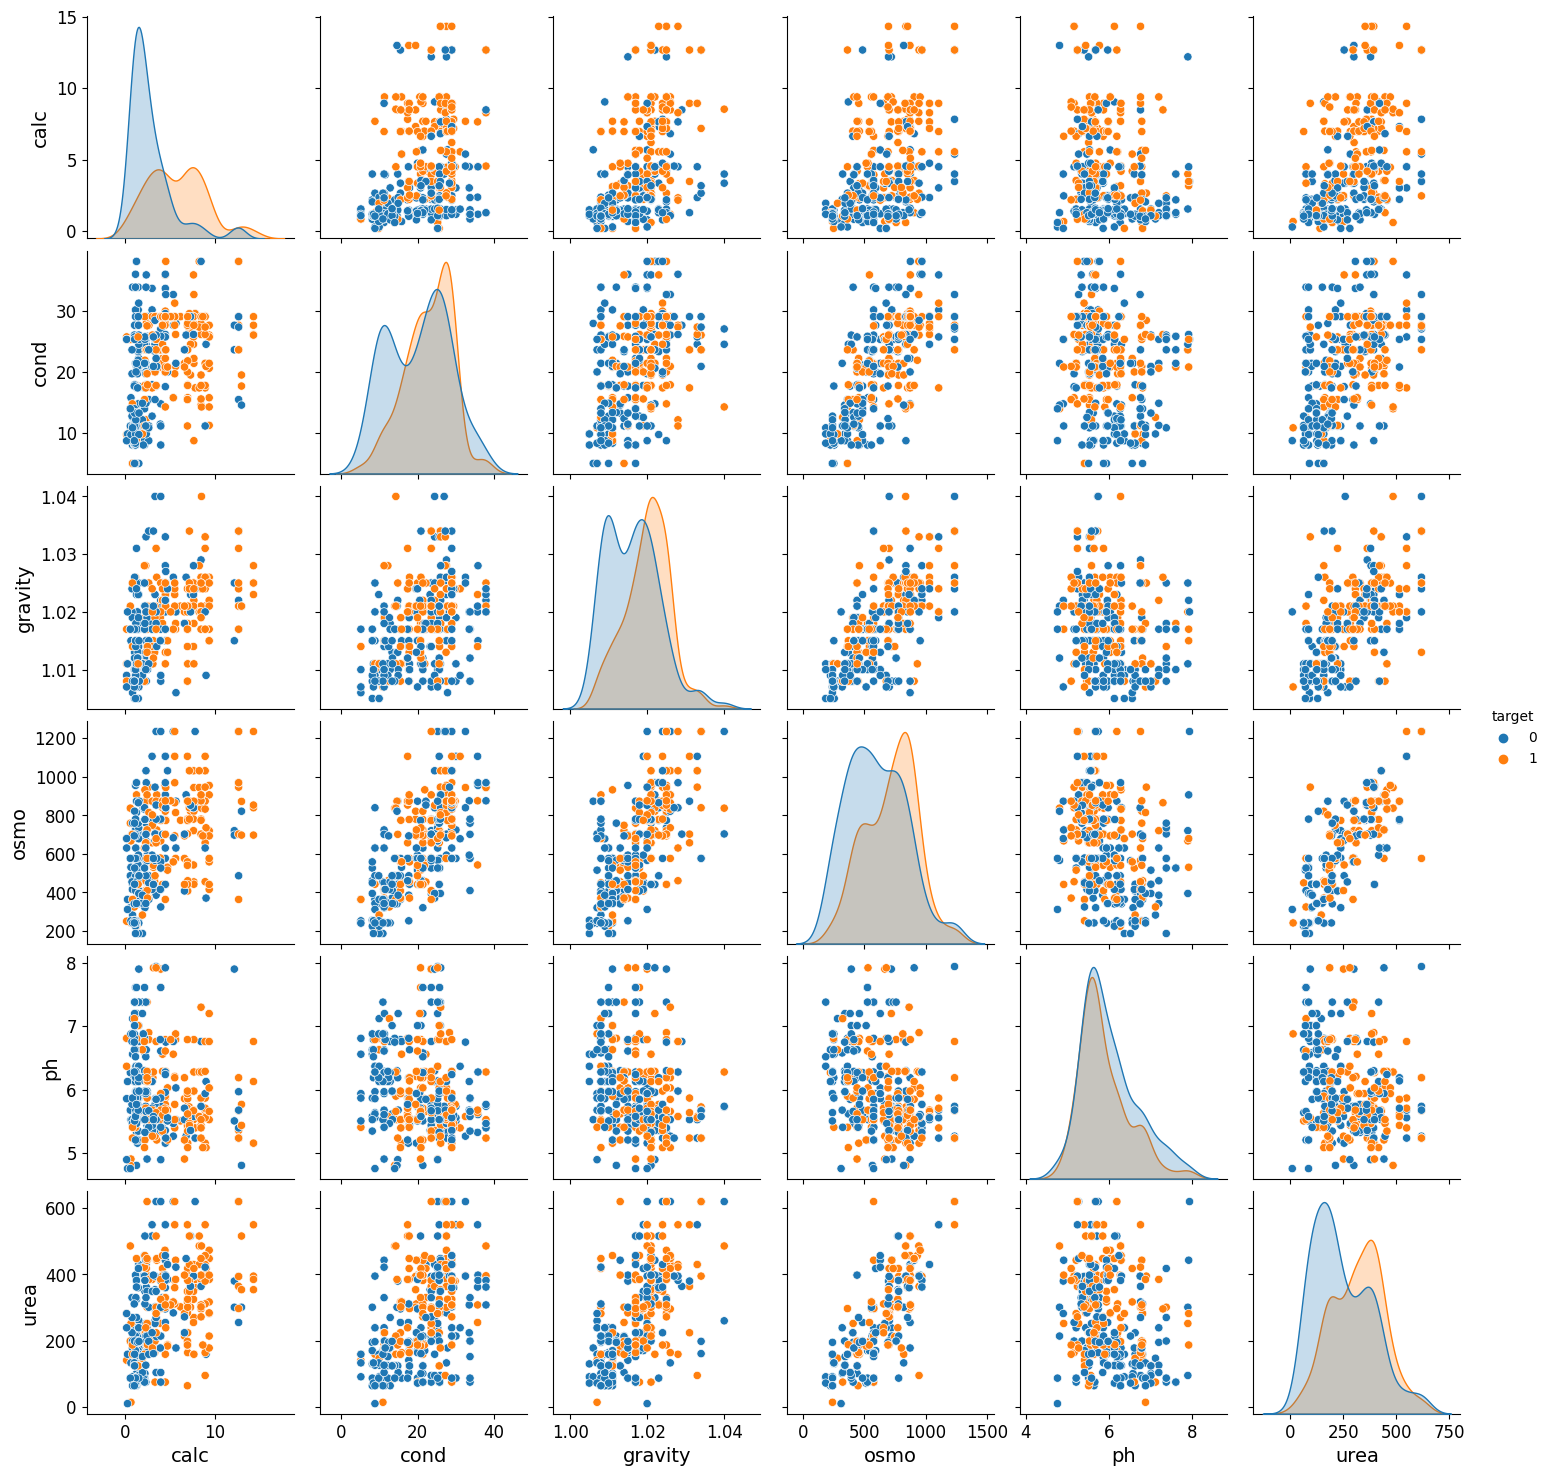

In [14]:
sns.pairplot(data=train_df,hue= 'target')

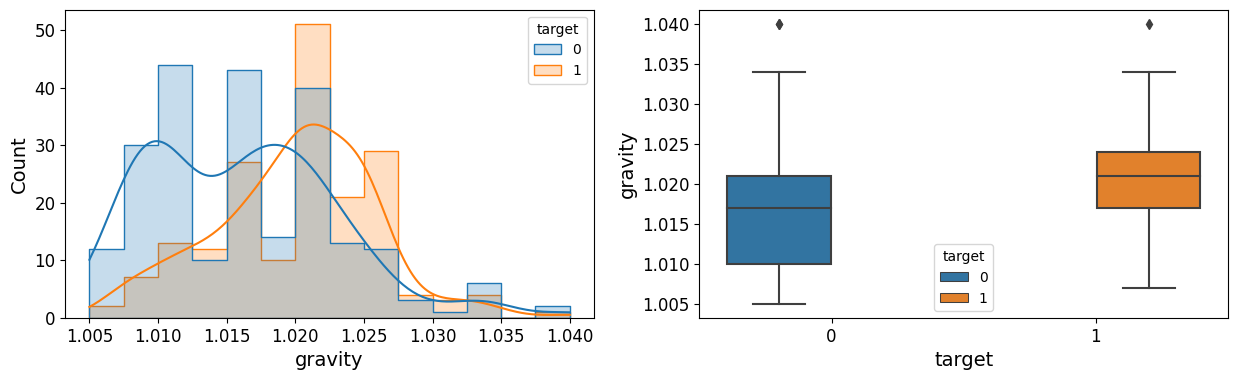

In [15]:
def plot_numerical_data(X,hue):
    fig, axes =plt.subplots(1, 2, figsize = (15,4))
    sns.histplot(ax = axes[0], x=X, hue=hue, data = train_df, element="step",kde=True)
    sns.boxplot(ax = axes[1], x=hue, y=X, hue=hue,data=train_df)

plot_numerical_data('gravity','target')

<span style="color:green">From density and box plot we can see  `specific gravity` after 1.020 shows increase in positives for kidney stones and drop in negatives which conclude that `heigh specefic gravity(above 1.020) can indicate persence of kidney stone but it alone can't say it surely`</span> 

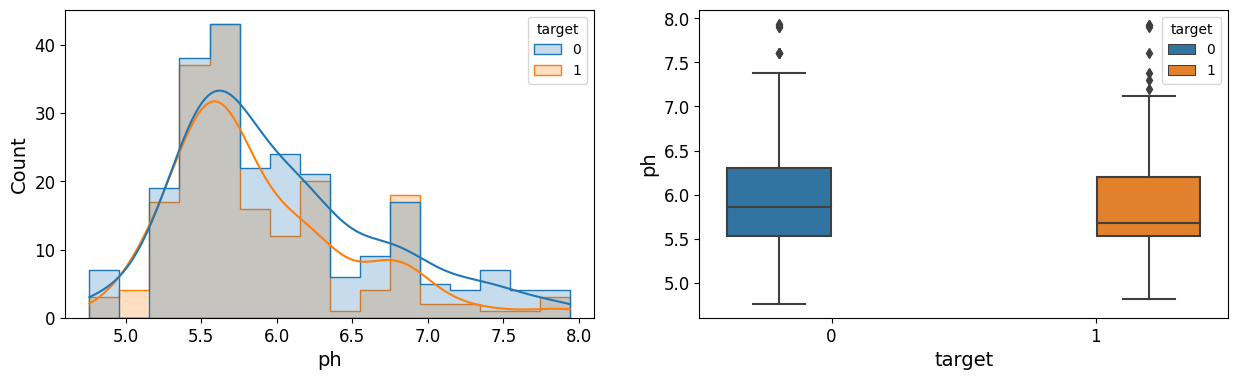

In [16]:
plot_numerical_data('ph','target')

In [17]:
def print_mean(col):
    df =train_df[col][train_df.target==0].describe()
    print("-ve mean & std:",train_df[col][train_df.target==0].mean(),"+-",train_df[col][train_df.target==0].std())
    print("+ve mean & std:",train_df[col][train_df.target==0].mean(),"+-",train_df[col][train_df.target==1].std())

print_mean('ph')

-ve mean & std: 6.00995652173913 +- 0.6693511802246994
+ve mean & std: 6.00995652173913 +- 0.6015716897109811


The distribution of both negitives and positives are simillar in this dataset
The `normal pH` of urine should ideally be `around 6.0 to 7.5` if the urine pH is `too acid` (`less than 5.5`) `or` if it is `too alkaline` `(greater than 7.2)` then there is a probability of kidney stones begin present

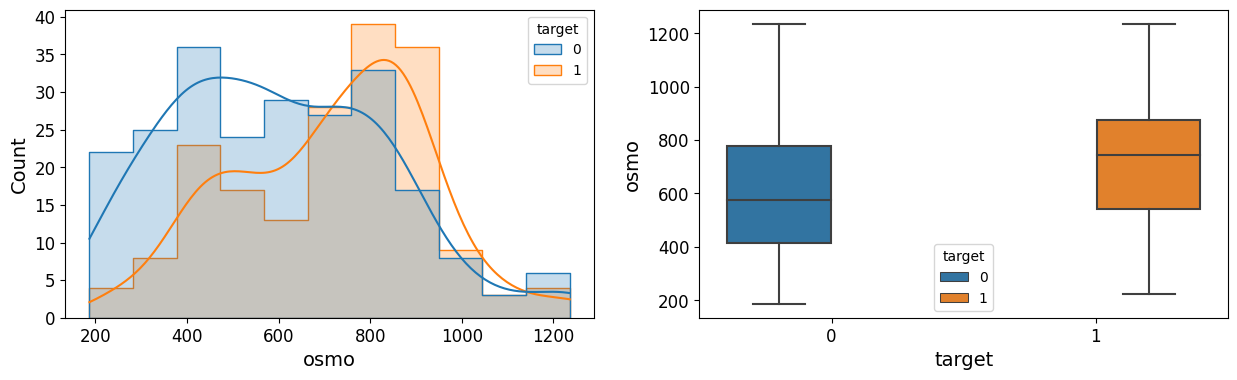

In [18]:
plot_numerical_data('osmo','target')

In [19]:
print_mean('osmo')

-ve mean & std: 600.2304347826087 +- 239.35797301187114
+ve mean & std: 600.2304347826087 +- 212.48649384775504


`Heigh Osmolarity` of above or around  800 can `indicate presence of kidney stones` whereas `low Osmolarity` `reduces the chances of kidney stones`

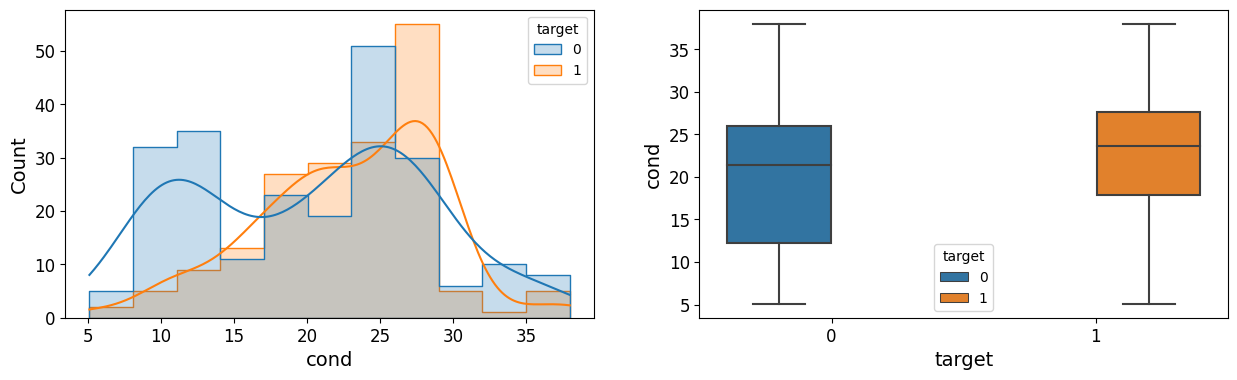

In [20]:
plot_numerical_data('cond','target')

low conductivty reduces the chances of kidney stones where as heigh conducvity can tells us presence of kidney stones 

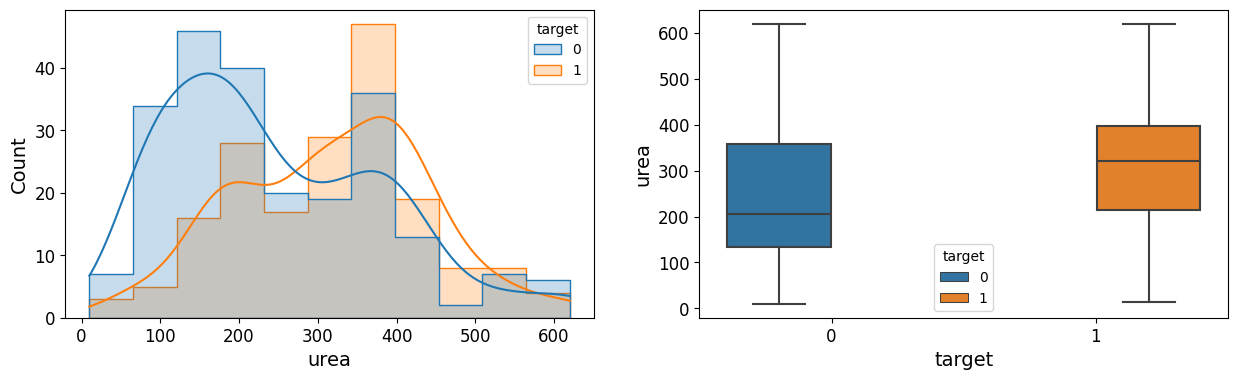

In [21]:
plot_numerical_data('urea','target')

In [22]:
print_mean('urea')

-ve mean & std: 246.3304347826087 +- 137.92661308849506
+ve mean & std: 246.3304347826087 +- 123.5048110253223


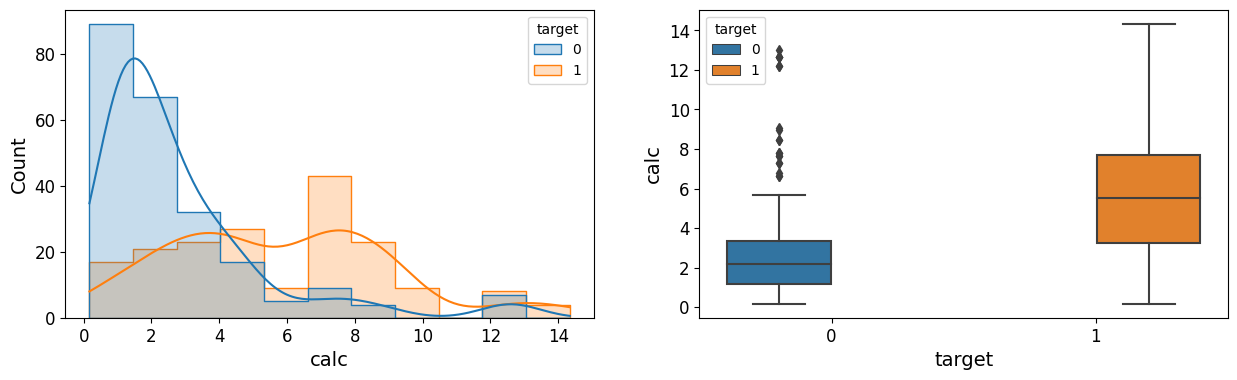

In [23]:
plot_numerical_data('calc','target')

In [24]:
print_mean('calc')

-ve mean & std: 2.7709999999999995 +- 2.4854074288406407
+ve mean & std: 2.7709999999999995 +- 3.2450135582137727


With `heigh concentration of calcium ` there is `more probability of kidney stones` begin present where as `low concentration of calcium reduces the risk of kidney stones`

# Correlation

<AxesSubplot: >

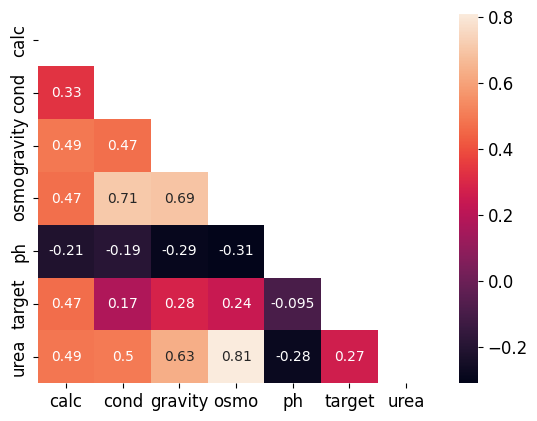

In [25]:
sns.heatmap(train_df.corr(), annot=True)
plt.show()

- osmo and urea shows very strong correlation 
- osmo:gravity and osmo & cond shows a pretty decent correlation. 
- Apart from all ph shows a negitive correaltion to target